In [5]:
import os
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import Accuracy, Precision, Recall, F1Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from livelossplot.inputs.keras import PlotLossesCallback

2024-02-02 15:16:20.473888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 15:16:20.509926: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 15:16:20.510709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 15:16:21.772005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
# paths 

data_path = "/home/devesh/Citadel/Assignments/Hewells/split_dataset_3"

In [7]:
# Constants

img_height = 224
img_width = 224

num_classes = 3
batch_size = 16

num_epochs = 100

## Data Preparation

In [8]:
# Assuming you have your images organized in separate folders for each class


datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to 0-1
    rotation_range=40,  # Rotate images randomly by up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    shear_range=0.2,  # Shear images randomly
    zoom_range=0.2,  # Zoom images randomly
    horizontal_flip=True,  # Flip images horizontally randomly
    fill_mode='nearest')  # Fill empty pixels with nearest neighbor interpolation


In [9]:
train_generator = datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 1449 images belonging to 3 classes.


In [10]:
test_generator = datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 183 images belonging to 3 classes.


In [11]:
val_generator = datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 181 images belonging to 3 classes.


In [12]:
label_map = (test_generator.class_indices)
class_map = dict((v,k) for k, v in label_map.items())

In [13]:
label_map

{'human': 0, 'no_human': 1, 'uber_eats': 2}

In [14]:
n_steps = train_generator.samples // batch_size
n_val_steps = val_generator.samples // batch_size
n_epochs = 100

print(n_steps)

90


## CNN Model

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))  # Output layer with number of classes

In [16]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [18]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

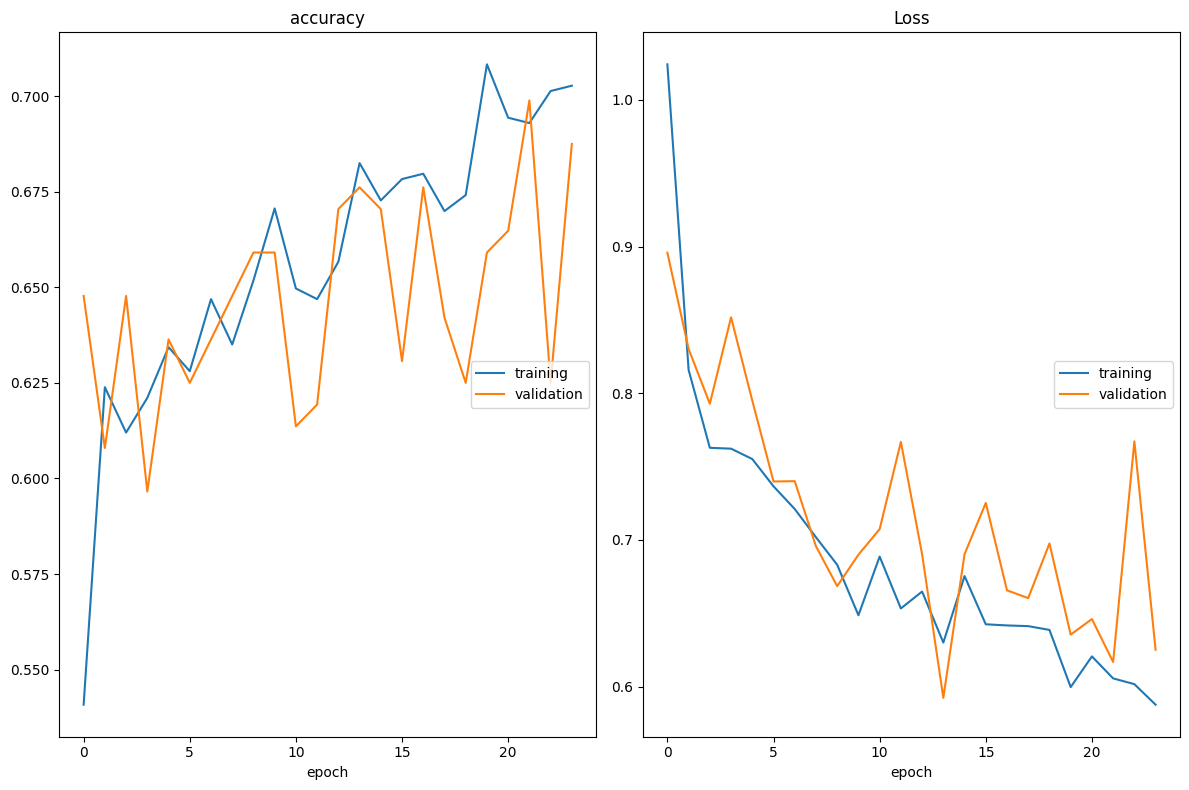

accuracy
	training         	 (min:    0.541, max:    0.708, cur:    0.703)
	validation       	 (min:    0.597, max:    0.699, cur:    0.688)
Loss
	training         	 (min:    0.588, max:    1.024, cur:    0.588)
	validation       	 (min:    0.592, max:    0.896, cur:    0.625)
90/90 [==============================] - 78s 861ms/step - loss: 0.5877 - accuracy: 0.7027 - val_loss: 0.6251 - val_accuracy: 0.6875


In [19]:
history = model.fit(train_generator,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=val_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from keras.models import load_model

In [21]:
def get_report():
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    model = load_model('tl_model_v1.weights.best.hdf5')
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    report1 = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
    report2 = classification_report(true_classes, predicted_classes, target_names=class_labels)

    print(report2)

In [22]:
get_report()

12/12 [==============================] - 7s 521ms/step
              precision    recall  f1-score   support

       human       0.36      0.52      0.42        62
    no_human       0.29      0.04      0.07        47
   uber_eats       0.43      0.50      0.46        74

    accuracy                           0.39       183
   macro avg       0.36      0.35      0.32       183
weighted avg       0.37      0.39      0.35       183

